# Starter Notebook

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q peft transformers datasets

In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

## Load Tokenizer and Preprocess Data

In [ ]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# Setting up the configuration for LoRA by changing r=2 to r=7
peft_config = LoraConfig(
    r=7,
    lora_alpha=4,
    lora_dropout=0.05,
    bias = 'none',
    target_modules = ['query'],
    task_type="SEQ_CLS",
)

In [ ]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [ ]:
# print("Trainable parameters:")
# for name, param in peft_model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 722,692 || all params: 125,371,400 || trainable%: 0.5764


In [ ]:
# load the previous model to resume our training
adapter_path = "./epoch5"
peft_model = PeftModel.from_pretrained(model, adapter_path)

## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Original version provided
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     # Calculate accuracy
#     accuracy = accuracy_score(labels, preds)
#     return {
#         'accuracy': accuracy

#     }

all_metrics = []

# Modified version
# We Computed additional classification metrics: precision, recall, and F1 score
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")

    # Combine all metrics into a dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    all_metrics.append(metrics)

    return metrics

In [ ]:
# Setup Training args

import os
os.environ["WANDB_DISABLED"] = "true"

# Directory to save model checkpoints and logs
output_dir = "results"

training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    # logging_strategy="steps",
    eval_strategy='epoch',  # Evaluate model at the end of each epoch
    # logging_steps=400,
    save_strategy='epoch', # Save model checkpoints at the end of each epoch
    learning_rate=5e-5,  # Learning rate for the optimizer
    num_train_epochs=5,
    # max_steps=1200,
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=64, # We changed the training batch size per device to 64
    per_device_eval_batch_size=64,
    # optim="sgd", # We use the default AdamW optimizer
    label_names=["labels"],
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True},
    # load_best_model_at_end=True,
    # metric_for_best_model="accuracy",
    # greater_is_better=True
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


### Start Training

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.161600,0.197530,0.925000,0.925366,0.925000,0.925072
2,0.160400,0.198245,0.925000,0.925302,0.925000,0.925061
3,0.163700,0.198691,0.928125,0.928372,0.928125,0.928146
4,0.158400,0.197967,0.928125,0.928344,0.928125,0.928174
5,0.172500,0.197901,0.929688,0.929920,0.929688,0.929733


In [ ]:
print(result)

TrainOutput(global_step=9325, training_loss=0.16476923883760264, metrics={'train_runtime': 2431.9357, 'train_samples_per_second': 245.401, 'train_steps_per_second': 3.834, 'total_flos': 1.0740438620510208e+17, 'train_loss': 0.16476923883760264, 'epoch': 5.0})


In [ ]:
print(all_metrics)

[{'accuracy': 0.925, 'precision': 0.9253658234126985, 'recall': 0.925, 'f1': 0.9250722420158976}, {'accuracy': 0.925, 'precision': 0.9253015241103772, 'recall': 0.925, 'f1': 0.9250605474879308}, {'accuracy': 0.928125, 'precision': 0.9283719286421317, 'recall': 0.928125, 'f1': 0.9281459578496463}, {'accuracy': 0.928125, 'precision': 0.9283443793378087, 'recall': 0.928125, 'f1': 0.9281744331585691}, {'accuracy': 0.9296875, 'precision': 0.9299202127659575, 'recall': 0.9296875, 'f1': 0.9297327336641853}]


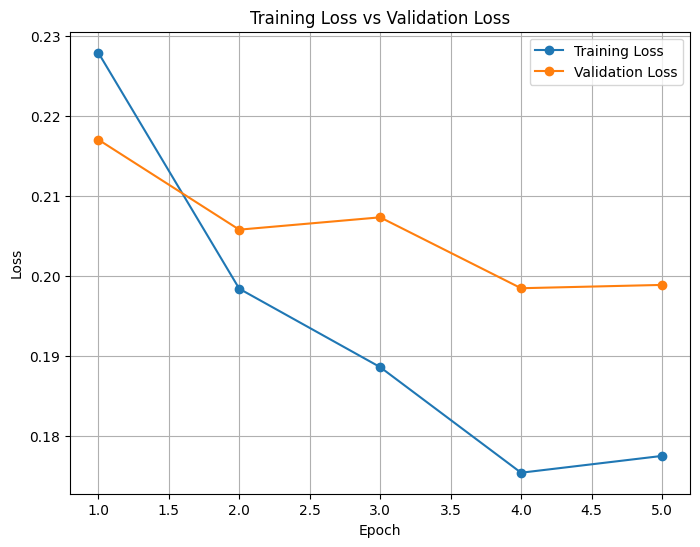

In [ ]:
# draw the loss change with different epochs
import matplotlib.pyplot as plt
epochs = [1, 2, 3, 4, 5]
training_loss = [0.227900, 0.198400, 0.188600, 0.175400, 0.177500]
validation_loss = [0.217035, 0.205782, 0.207324, 0.198462, 0.198876]

plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

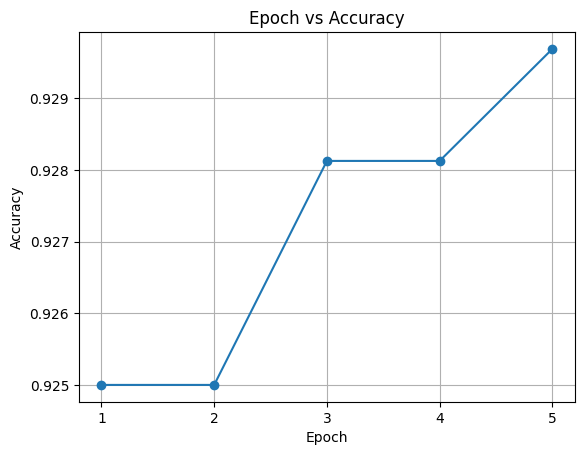

In [ ]:
epochs = list(range(1, len(all_metrics) + 1))

accuracy = [m['accuracy'] for m in all_metrics]
precision = [m['precision'] for m in all_metrics]
recall = [m['recall'] for m in all_metrics]
f1 = [m['f1'] for m in all_metrics]

# draw Accuracy change
plt.figure()
plt.xticks(epochs)
plt.plot(epochs, accuracy, marker='o')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()




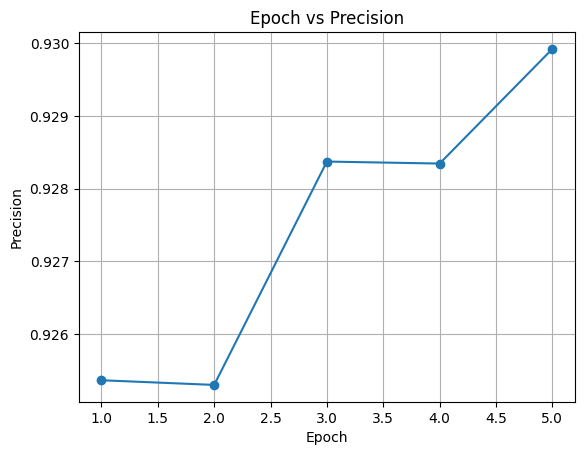

In [ ]:
# draw Precision change
plt.figure()
plt.plot(epochs, precision, marker='o')
plt.title('Epoch vs Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

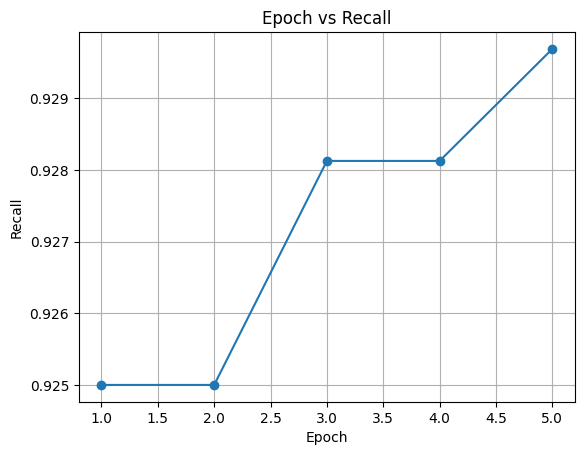

In [ ]:
# draw Recall change
plt.figure()
plt.plot(epochs, recall, marker='o')
plt.title('Epoch vs Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.show()



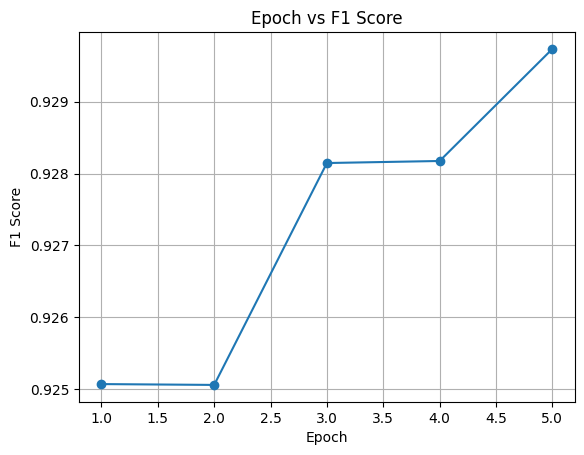

In [ ]:
# draw F1 Score change
plt.figure()
plt.plot(epochs, f1, marker='o')
plt.title('Epoch vs F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
adapter_path = "./results/checkpoint-5595"
model1 = PeftModel.from_pretrained(model, adapter_path)
model1 = model1.merge_and_unload()

In [ ]:
# def classify(model, tokenizer, text):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
#     output = model(**inputs)

#     prediction = output.logits.argmax(dim=-1).item()

#     print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
#     return id2label[prediction]

In [ ]:
# classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
# classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:03<00:00, 26.65it/s]

Evaluation Metric: {'accuracy': 0.9296875}


In [ ]:
# download all produced files
!zip -r results.zip results

from google.colab import files
files.download("results.zip")

  adding: results/ (stored 0%)
  adding: results/checkpoint-5595/ (stored 0%)
  adding: results/checkpoint-5595/trainer_state.json (deflated 71%)
  adding: results/checkpoint-5595/README.md (deflated 66%)
  adding: results/checkpoint-5595/merges.txt (deflated 53%)
  adding: results/checkpoint-5595/vocab.json (deflated 68%)
  adding: results/checkpoint-5595/scheduler.pt (deflated 55%)
  adding: results/checkpoint-5595/special_tokens_map.json (deflated 84%)
  adding: results/checkpoint-5595/tokenizer_config.json (deflated 76%)
  adding: results/checkpoint-5595/optimizer.pt (deflated 8%)
  adding: results/checkpoint-5595/rng_state.pth (deflated 25%)
  adding: results/checkpoint-5595/training_args.bin (deflated 51%)
  adding: results/checkpoint-5595/adapter_config.json (deflated 55%)
  adding: results/checkpoint-5595/adapter_model.safetensors (deflated 7%)
  adding: results/checkpoint-9325/ (stored 0%)
  adding: results/checkpoint-9325/trainer_state.json (deflated 74%)
  adding: results/ch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Graphs

In [ ]:
# Connect to google drive to load the stored epochs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Evaluating epoch 1...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 80/80 [00:03<00:00, 22.98it/s]


Evaluation Metric: {'accuracy': 0.9234375}
Evaluating epoch 2...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.59it/s]


Evaluation Metric: {'accuracy': 0.9296875}
Evaluating epoch 3...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.41it/s]


Evaluation Metric: {'accuracy': 0.9296875}
Evaluating epoch 4...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.29it/s]


Evaluation Metric: {'accuracy': 0.928125}
Evaluating epoch 5...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.39it/s]


Evaluation Metric: {'accuracy': 0.9296875}
Evaluating epoch 6...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.52it/s]


Evaluation Metric: {'accuracy': 0.925}
Evaluating epoch 7...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.49it/s]


Evaluation Metric: {'accuracy': 0.925}
Evaluating epoch 8...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.36it/s]


Evaluation Metric: {'accuracy': 0.928125}
Evaluating epoch 9...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.51it/s]


Evaluation Metric: {'accuracy': 0.928125}
Evaluating epoch 10...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.57it/s]


Evaluation Metric: {'accuracy': 0.9296875}
Evaluating epoch 11...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.47it/s]


Evaluation Metric: {'accuracy': 0.9265625}
Evaluating epoch 12...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.67it/s]


Evaluation Metric: {'accuracy': 0.9265625}
Evaluating epoch 13...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.65it/s]


Evaluation Metric: {'accuracy': 0.93125}
Evaluating epoch 14...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.47it/s]


Evaluation Metric: {'accuracy': 0.928125}
Evaluating epoch 15...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.81it/s]


Evaluation Metric: {'accuracy': 0.928125}
Evaluating epoch 16...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.53it/s]


Evaluation Metric: {'accuracy': 0.9265625}
Evaluating epoch 17...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.93it/s]


Evaluation Metric: {'accuracy': 0.925}
Evaluating epoch 18...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.73it/s]


Evaluation Metric: {'accuracy': 0.928125}
Evaluating epoch 19...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.68it/s]


Evaluation Metric: {'accuracy': 0.9234375}
Evaluating epoch 20...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.49it/s]


Evaluation Metric: {'accuracy': 0.925}
Evaluating epoch 21...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.76it/s]


Evaluation Metric: {'accuracy': 0.925}
Evaluating epoch 22...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.66it/s]


Evaluation Metric: {'accuracy': 0.928125}
Evaluating epoch 23...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.53it/s]


Evaluation Metric: {'accuracy': 0.925}


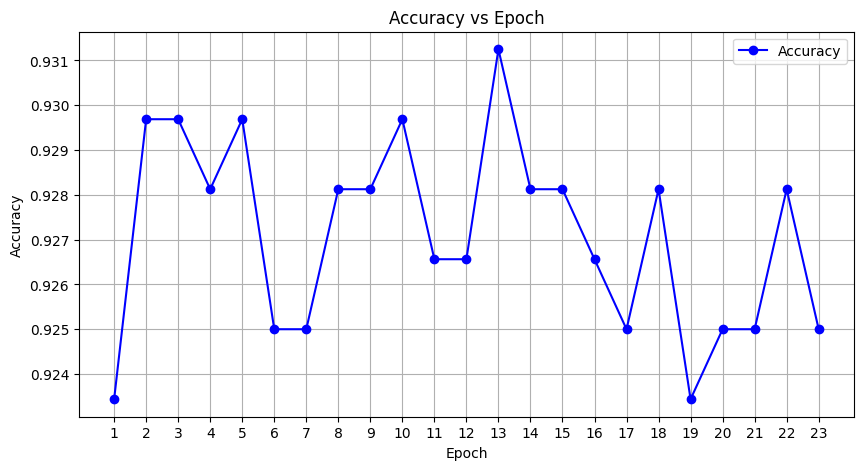

In [ ]:
import os
import matplotlib.pyplot as plt

# Load the checking points
base_model_path = "/content/drive/MyDrive/lora_project"

# Epoch numbers to evaluate (from 1 to 23)
epoch_nums = list(range(1, 24))
accuracies = []

for epoch in epoch_nums:
    print(f"Evaluating epoch {epoch}...")

    adapter_path = os.path.join(base_model_path, f"epoch{epoch}")

    # Load a fresh copy of the base model
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", id2label=id2label)

    # Inject the LoRA adapter weights from the current epoch
    peft_model = PeftModel.from_pretrained(model, adapter_path)

    # Merge LoRA adapter into the base model
    merged_model = peft_model.merge_and_unload()

    # Evaluate the model on the validation set using evaluate function
    metric, _ = evaluate_model(merged_model, eval_dataset, labelled=True, batch_size=8, data_collator=data_collator)
    acc = metric["accuracy"]
    accuracies.append(acc)

# Draw the graph of accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_nums, accuracies, marker='o', color='blue', label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.grid(True)
plt.xticks(epoch_nums)
plt.legend()
plt.show()

Loading metrics from epoch 1...
Loading metrics from epoch 2...
Loading metrics from epoch 3...
Loading metrics from epoch 4...
Loading metrics from epoch 5...
Loading metrics from epoch 6...
Loading metrics from epoch 7...
Loading metrics from epoch 8...
Loading metrics from epoch 9...
Loading metrics from epoch 10...
Loading metrics from epoch 11...
Loading metrics from epoch 12...
Loading metrics from epoch 13...
Loading metrics from epoch 14...
Loading metrics from epoch 15...
Loading metrics from epoch 16...
Loading metrics from epoch 17...
Loading metrics from epoch 18...
Loading metrics from epoch 19...
Loading metrics from epoch 20...
Loading metrics from epoch 21...
Loading metrics from epoch 22...
Loading metrics from epoch 23...


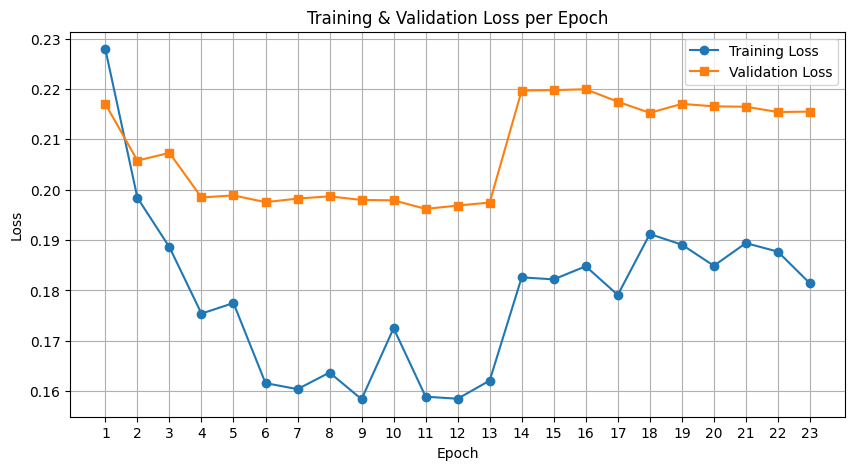

In [ ]:
import json

# Store the training and validation losses for each epoch
train_losses = []
val_losses = []

for epoch in epoch_nums:
    print(f"Loading metrics from epoch {epoch}...")

    checkpoint_path = os.path.join(base_model_path, f"epoch{epoch}")
    trainer_state_path = os.path.join(checkpoint_path, "trainer_state.json")

    if not os.path.exists(trainer_state_path):
        print(f"No trainer_state.json found for epoch {epoch}, skipping.")
        continue

    # Load the JSON log file
    with open(trainer_state_path, "r") as f:
        state = json.load(f)

    # Extract the log history list
    logs = state.get("log_history", [])

    # Find the last recorded validation loss and training loss from the logs (search in reverse)
    last_eval_loss = next((log["eval_loss"] for log in reversed(logs) if "eval_loss" in log), None)
    last_train_loss = next((log["loss"] for log in reversed(logs) if "loss" in log), None)

    # Append the losses to the corresponding lists
    train_losses.append(last_train_loss)
    val_losses.append(last_eval_loss)

plt.figure(figsize=(10, 5))
plt.plot(epoch_nums, train_losses, marker='o', label="Training Loss")
plt.plot(epoch_nums, val_losses, marker='s', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.grid(True)
plt.xticks(epoch_nums)
plt.legend()
plt.show()

When we did the training for epoch 14-23, we ran the peft_model code which slightly changed the base model, so the training loss and validation loss we got during the training is slightly different from calculating those losses from the original base model>

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

# Create a modified evaluate function to evaluate precision, recall, and f1
def evaluate_model2(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Returns:
        If labelled=True: returns (metrics_dict, predictions)
        If labelled=False: returns predictions only
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    all_labels = []

    for batch in tqdm(eval_dataloader):
        labels = batch["labels"].to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

        # Perform forward pass without gradient tracking
        with torch.no_grad():
            outputs = inference_model(**inputs)
        predictions = outputs.logits.argmax(dim=-1)

        # Store predictions and labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    if labelled:
        acc = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        metrics = {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
        print("Evaluation Metric:", metrics)
        return metrics, all_predictions
    else:
        return all_predictions

Evaluating epoch 1...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 27.97it/s]


Evaluation Metric: {'accuracy': 0.9234375, 'precision': 0.923614804964539, 'recall': 0.9234375, 'f1': 0.9234558284457478}
Evaluating epoch 2...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.48it/s]


Evaluation Metric: {'accuracy': 0.9296875, 'precision': 0.9300460232314137, 'recall': 0.9296875, 'f1': 0.929644897378893}
Evaluating epoch 3...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.30it/s]


Evaluation Metric: {'accuracy': 0.9296875, 'precision': 0.9299863776399828, 'recall': 0.9296875, 'f1': 0.9296681840332411}
Evaluating epoch 4...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.63it/s]


Evaluation Metric: {'accuracy': 0.928125, 'precision': 0.9285139036694525, 'recall': 0.928125, 'f1': 0.9282021837247504}
Evaluating epoch 5...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.47it/s]


Evaluation Metric: {'accuracy': 0.9296875, 'precision': 0.9299919281433489, 'recall': 0.9296875, 'f1': 0.9297496167031228}
Evaluating epoch 6...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.33it/s]


Evaluation Metric: {'accuracy': 0.925, 'precision': 0.9253658234126985, 'recall': 0.925, 'f1': 0.9250722420158976}
Evaluating epoch 7...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.47it/s]


Evaluation Metric: {'accuracy': 0.925, 'precision': 0.9253015241103772, 'recall': 0.925, 'f1': 0.9250605474879308}
Evaluating epoch 8...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.54it/s]


Evaluation Metric: {'accuracy': 0.928125, 'precision': 0.9283719286421317, 'recall': 0.928125, 'f1': 0.9281459578496463}
Evaluating epoch 9...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.51it/s]


Evaluation Metric: {'accuracy': 0.928125, 'precision': 0.9283443793378087, 'recall': 0.928125, 'f1': 0.9281744331585691}
Evaluating epoch 10...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.61it/s]


Evaluation Metric: {'accuracy': 0.9296875, 'precision': 0.9299202127659575, 'recall': 0.9296875, 'f1': 0.9297327336641853}
Evaluating epoch 11...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.39it/s]


Evaluation Metric: {'accuracy': 0.9265625, 'precision': 0.9269628171992481, 'recall': 0.9265625, 'f1': 0.9266293021444204}
Evaluating epoch 12...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.60it/s]


Evaluation Metric: {'accuracy': 0.9265625, 'precision': 0.9267852036147335, 'recall': 0.9265625, 'f1': 0.9266161878661879}
Evaluating epoch 13...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.67it/s]


Evaluation Metric: {'accuracy': 0.93125, 'precision': 0.9314153179877914, 'recall': 0.93125, 'f1': 0.9312691070572019}
Evaluating epoch 14...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.59it/s]


Evaluation Metric: {'accuracy': 0.928125, 'precision': 0.928068278015594, 'recall': 0.928125, 'f1': 0.9279919710823685}
Evaluating epoch 15...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.60it/s]


Evaluation Metric: {'accuracy': 0.928125, 'precision': 0.9280649614743786, 'recall': 0.928125, 'f1': 0.9279474854625812}
Evaluating epoch 16...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.64it/s]


Evaluation Metric: {'accuracy': 0.9265625, 'precision': 0.9265373624151506, 'recall': 0.9265625, 'f1': 0.926408016639264}
Evaluating epoch 17...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.56it/s]


Evaluation Metric: {'accuracy': 0.925, 'precision': 0.9250119367430034, 'recall': 0.925, 'f1': 0.9248174250852015}
Evaluating epoch 18...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.47it/s]


Evaluation Metric: {'accuracy': 0.928125, 'precision': 0.92809342775901, 'recall': 0.928125, 'f1': 0.9279948131039493}
Evaluating epoch 19...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.65it/s]


Evaluation Metric: {'accuracy': 0.9234375, 'precision': 0.9233784140157308, 'recall': 0.9234375, 'f1': 0.9232202028629792}
Evaluating epoch 20...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.63it/s]


Evaluation Metric: {'accuracy': 0.925, 'precision': 0.9249201139977927, 'recall': 0.925, 'f1': 0.9248134461820492}
Evaluating epoch 21...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.43it/s]


Evaluation Metric: {'accuracy': 0.925, 'precision': 0.9250119367430034, 'recall': 0.925, 'f1': 0.9248174250852015}
Evaluating epoch 22...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.62it/s]


Evaluation Metric: {'accuracy': 0.928125, 'precision': 0.9280532324759019, 'recall': 0.928125, 'f1': 0.9279991959046047}
Evaluating epoch 23...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 80/80 [00:02<00:00, 28.70it/s]


Evaluation Metric: {'accuracy': 0.925, 'precision': 0.9249201139977927, 'recall': 0.925, 'f1': 0.9248134461820492}


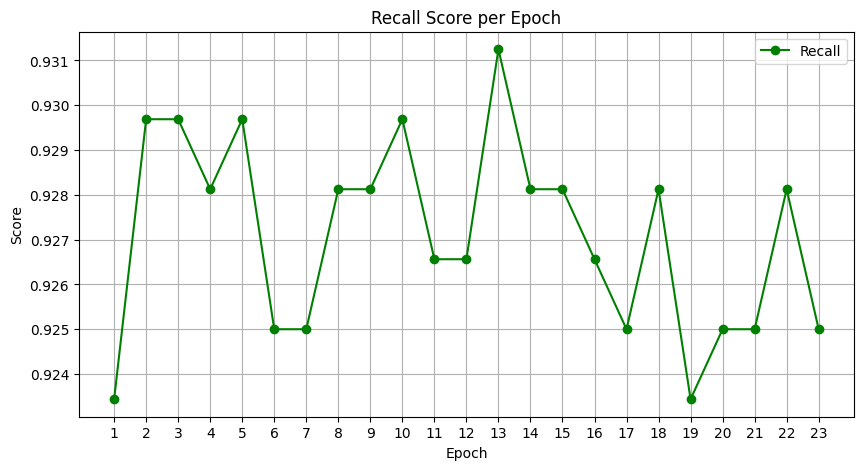

In [ ]:
recalls = []
f1s = []
precisions = []

# Loop through each saved epoch checkpoint directory
for epoch in epoch_nums:
    print(f"Evaluating epoch {epoch}...")

    adapter_path = os.path.join(base_model_path, f"epoch{epoch}")

    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
    peft_model = PeftModel.from_pretrained(model, adapter_path)
    merged_model = peft_model.merge_and_unload()

    # Evaluate the model using custom evaluate_model2 function
    metric, _ = evaluate_model2(merged_model, eval_dataset, labelled=True, batch_size=8, data_collator=data_collator)

    # Extract and store the relevant metrics from the evaluation result
    recalls.append(metric.get("recall", None))
    f1s.append(metric.get("f1", None))
    precisions.append(metric.get("precision", None))

# Draw the graph for Recall score
plt.figure(figsize=(10, 5))
plt.plot(epoch_nums, recalls, marker='o', label="Recall", color='green')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Recall Score per Epoch")
plt.grid(True)
plt.xticks(epoch_nums)
plt.legend()
plt.show()

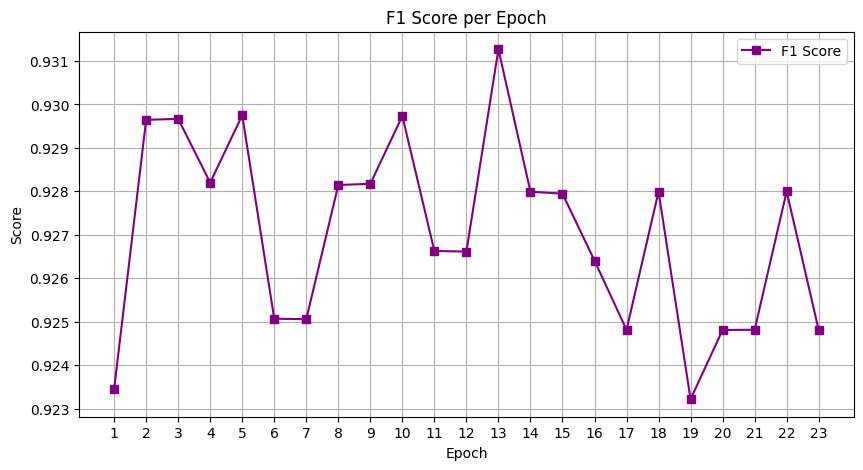

In [ ]:
# Draw the graph for F1 score
plt.figure(figsize=(10, 5))
plt.plot(epoch_nums, f1s, marker='s', label="F1 Score", color='purple')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("F1 Score per Epoch")
plt.grid(True)
plt.xticks(epoch_nums)
plt.legend()
plt.show()

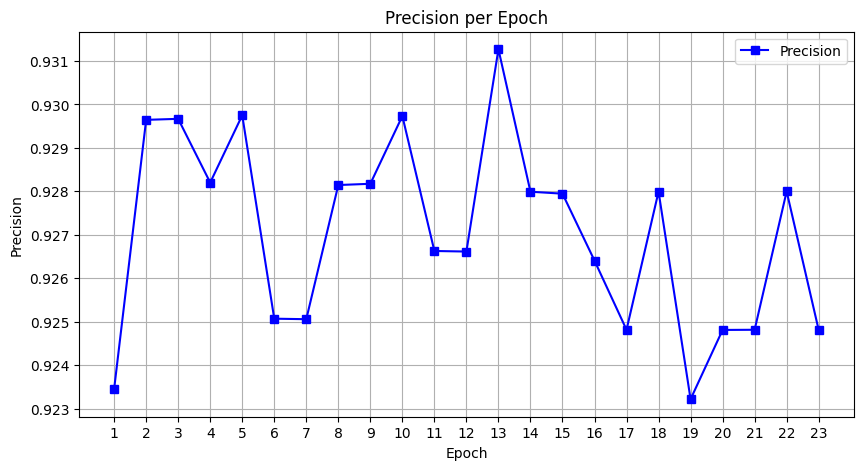

In [ ]:
# Draw the graph for Precision
plt.figure(figsize=(10, 5))
plt.plot(epoch_nums, f1s, marker='s', label="Precision", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision per Epoch")
plt.grid(True)
plt.xticks(epoch_nums)
plt.legend()
plt.show()

In [ ]:
# Draw the table for all the parameters
df = pd.DataFrame({
    "epoch": epoch_nums,
    "accuracy": accuracies,
    "precision": precisions,
    "recall": recalls,
    "f1": f1s,
    "train_loss": train_losses,
    "val_loss": val_losses
})

print(df)

    epoch  accuracy  precision    recall        f1  train_loss  val_loss
0       1  0.923438   0.923615  0.923438  0.923456      0.2279  0.217035
1       2  0.929688   0.930046  0.929688  0.929645      0.1984  0.205782
2       3  0.929688   0.929986  0.929688  0.929668      0.1886  0.207324
3       4  0.928125   0.928514  0.928125  0.928202      0.1754  0.198462
4       5  0.929688   0.929992  0.929688  0.929750      0.1775  0.198876
5       6  0.925000   0.925366  0.925000  0.925072      0.1616  0.197530
6       7  0.925000   0.925302  0.925000  0.925061      0.1604  0.198245
7       8  0.928125   0.928372  0.928125  0.928146      0.1637  0.198691
8       9  0.928125   0.928344  0.928125  0.928174      0.1584  0.197967
9      10  0.929688   0.929920  0.929688  0.929733      0.1725  0.197901
10     11  0.926562   0.926963  0.926562  0.926629      0.1589  0.196192
11     12  0.926562   0.926785  0.926562  0.926616      0.1585  0.196857
12     13  0.931250   0.931415  0.931250  0.931269 

### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:28<00:00, 34.91it/s]

Inference complete. Predictions saved to inference_output.csv
